# **ĐANG SUY NGHĨ XEM NÊN VIẾT CÁI GÌ ĐỂ GIỚI THIỆU**

# **Mount to Gdrive**

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# **Import requirement lib**

In [2]:
import os # used to handle files using system commands.
import pickle # used to store numpy features extracted
import numpy as np  # used to perform a wide variety of mathematical operations 
                    # on arrays
from tqdm.notebook import tqdm  # progress bar decorator for iterators. 
                                # Includes a default range iterator printing to 
                                # stderr.

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input 
    # imported modules for feature extraction from the image data
from tensorflow.keras.preprocessing.image import load_img, img_to_array
    # used for loading the image and converting the image to a numpy array
from tensorflow.keras.preprocessing.text import Tokenizer
    # used for loading the text as convert them into a token
from tensorflow.keras.preprocessing.sequence import pad_sequences
    # used for equal distribution of words in sentences filling the remaining 
    # spaces with zeros
from tensorflow.keras.models import Model
    # stored model
from tensorflow.keras.utils import to_categorical, plot_model
    # used to visualize the architecture of the model through different images
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
    # operation for advanced model option

# **Prepare Captions Data for Generator**

## **Load caption with imgID**

In [3]:
with open('/content/gdrive/MyDrive/Đồ án/Machine learning/Image captioning/Caption with imgID/caption_with_imgID_flickr.pkl', 'rb') as f:
    mapping = pickle.load(f)

In [4]:
mapping

{'1000268201_693b08cb0e': ['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
  'startseq girl going into wooden building endseq',
  'startseq little girl climbing into wooden playhouse endseq',
  'startseq little girl climbing the stairs to her playhouse endseq',
  'startseq little girl in pink dress going into wooden cabin endseq'],
 '1001773457_577c3a7d70': ['startseq black dog and spotted dog are fighting endseq',
  'startseq black dog and tricolored dog playing with each other on the road endseq',
  'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
  'startseq two dogs of different breeds looking at each other on the road endseq',
  'startseq two dogs on pavement moving toward each other endseq'],
 '1002674143_1b742ab4b8': ['startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq',
  'startseq little girl is sitting in front of large painted rainbow endse

## **Stored mapping as list**

In [5]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [6]:
all_captions

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tricolored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq',
 'startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq',
 'startseq little girl is sitting in front of large painted rainbow endseq',
 'startseq small girl in the grass plays with fingerpaints in front of white canvas w

In [7]:
len(all_captions)

40455

## **Create a vocabulary**

In [8]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [9]:
vocab_size

8768

## **Define a batch and include the padding sequence**

In [10]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

34

In [11]:
# Explanatory example of the sequence split into pairs

# startseq girl going into wooden building endseq
#        X                   y
# startseq                   girl
# startseq girl              going
# startseq girl going        into
# ...........
# startseq girl going into wooden building      endseq

In [12]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
  # data_keys: imgID
  # mapping: map of caption with imgID (mapping above)
  # features: fetures of image are extracted
  # tokenizer: a vocab save with name "tokenizer" (tokenizer varible)
  # max_length: max length caption we got
  # vocab size: SIze of vocabulary (vocab_size varible)
  # batch_size: batch size of data training for each epoch

  # loop over images
  X1, X2, y = list(), list(), list()
  n = 0
  while 1:
    for key in data_keys:
      n += 1
      # get caption with key
      captions = mapping[key]

      # process each caption
      for caption in captions:
        # encode caption to the sequence
        seq = tokenizer.texts_to_sequences([caption])[0]

        # split the sequence into X, y pairs
        for i in range(1, len(seq)):
          # split into input and output pairs
          in_seq, out_seq = seq[:i], seq[i]
          # pad input sequence
          in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
          # encode output sequence
          out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
          # store the sequences
          X1.append(features[key][0])
          X2.append(in_seq)
          y.append(out_seq)
      if n == batch_size:
          X1, X2, y = np.array(X1), np.array(X2), np.array(y)
          yield [X1, X2], y
          X1, X2, y = list(), list(), list()
          n = 0

# **Model creation**

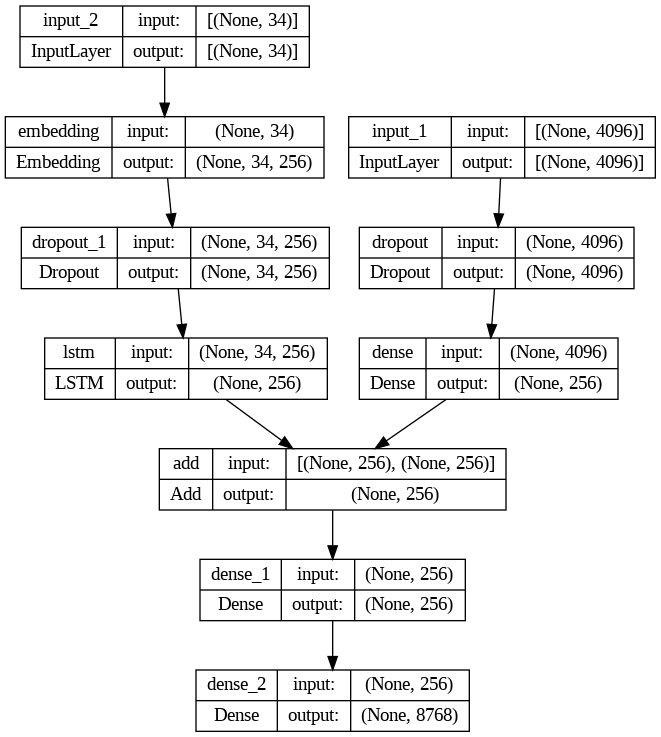

In [13]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

# **Training**

## **Load feature img**

In [14]:
import pickle

# Load
with open('/content/gdrive/MyDrive/Đồ án/Machine learning/Image captioning/Extracted feature/featured_extracted_flickr.pkl', 'rb') as f:
    features = pickle.load(f)

In [15]:
features

{'300577375_26cc2773a1': array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 '3468694409_a51571d621': array([[4.0797954 , 0.        , 0.        , ..., 0.39524114, 0.        ,
         0.46249932]], dtype=float32),
 '357725852_6f55cb9abc': array([[3.9487529, 3.4432902, 0.       , ..., 0.       , 1.1390073,
         0.       ]], dtype=float32),
 '2449446913_28fa5b7c75': array([[0.       , 0.       , 0.       , ..., 0.       , 0.5456462,
         0.       ]], dtype=float32),
 '191003285_edd8d0cf58': array([[1.0855836, 1.2068305, 0.       , ..., 0.       , 0.       ,
         4.1206703]], dtype=float32),
 '3209966887_5b744bd050': array([[0.        , 0.        , 0.        , ..., 0.        , 0.5690081 ,
         0.67263347]], dtype=float32),
 '371522748_dc557bcd6c': array([[0.02463943, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]], dtype=float32),
 '3534046564_4f8546e364': array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 '1456393634_74022d9056': array(

## **Check Captions data mapping**

In [16]:
mapping

{'1000268201_693b08cb0e': ['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
  'startseq girl going into wooden building endseq',
  'startseq little girl climbing into wooden playhouse endseq',
  'startseq little girl climbing the stairs to her playhouse endseq',
  'startseq little girl in pink dress going into wooden cabin endseq'],
 '1001773457_577c3a7d70': ['startseq black dog and spotted dog are fighting endseq',
  'startseq black dog and tricolored dog playing with each other on the road endseq',
  'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
  'startseq two dogs of different breeds looking at each other on the road endseq',
  'startseq two dogs on pavement moving toward each other endseq'],
 '1002674143_1b742ab4b8': ['startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq',
  'startseq little girl is sitting in front of large painted rainbow endse

## **Training**

In [17]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.80)
train = image_ids[:split]
test = image_ids[split:]

In [18]:
# train the model
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

202/202 [==============================] - 62s 305ms/step - loss: 2.1586


## **Save model**

In [19]:
model.save('/content/best_model_15_02_2023_20Epoches.h5')

In [20]:
! mkdir '/content/gdrive/MyDrive/Đồ án/Machine learning/Image captioning/model'

mkdir: cannot create directory ‘/content/gdrive/MyDrive/Đồ án/Machine learning/Image captioning/model’: File exists


In [21]:
! cp '/content/best_model_15_02_2023_20Epoches.h5' '/content/gdrive/MyDrive/Đồ án/Machine learning/Image captioning/model'

## **Make backup/recovery file**

In [22]:
! mkdir '/content/gdrive/MyDrive/Đồ án/Machine learning/Image captioning/model/Backup files'
! cp '/content/best_model_15_02_2023_20Epoches.h5' '/content/gdrive/MyDrive/Đồ án/Machine learning/Image captioning/model/Backup files'

mkdir: cannot create directory ‘/content/gdrive/MyDrive/Đồ án/Machine learning/Image captioning/model/Backup files’: File exists
cp: cannot create regular file '/content/gdrive/MyDrive/Đồ án/Đồ án Thị giác máy tính nâng cao/Final/model/Backup files/best_model_15_02_2023_20Epoches.h5': Read-only file system
